<a href="https://colab.research.google.com/github/gusmaomarcos/Avancando-em-Data-Science-com-Python/blob/main/meteora_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Alt text: Slogan da Meteora.](https://i.imgur.com/VDYh2G1.png)

# 1. Estruturando a tabela

**Meteora** é uma loja que vende roupas e acessórios de diversas marcas por todos os estados do Brasil, para entender suas bases de dados e exibir informações relevantes com o objetivo de auxiliar suas tomadas de decisão.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, text

**Sobre as tabelas**

* itens_pedidos: tabela que informa sobre o que foi vendido, vai ter informação o preço, quantidade, para onde vai ser enviado e o frete do pedido
* pedidos: vai falar sobre a venda feita, tendo informação sobre os vendedores, preço do pedido e a data da venda
* produtos: informa características dos produtos que são comercializados na loja
* vendedores: informa o nome dos vendedores.

In [2]:
url_itens_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/itens_pedidos.csv'
url_pedidos = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/pedidos.csv'
url_produto = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/produtos.csv'
url_vendedores = 'https://github.com/alura-cursos/SQL-python-integracao/raw/main/TABELAS/vendedores.csv'

In [3]:
itens_pedidos = pd.read_csv(url_itens_pedidos)
pedidos = pd.read_csv(url_pedidos)
produtos = pd.read_csv(url_produto)
vendedores = pd.read_csv(url_vendedores)

In [4]:
engine = create_engine('sqlite:///:memory:')

In [5]:
produtos.to_sql('produtos', engine, index=False)
itens_pedidos.to_sql('itens_pedidos', engine, index=False)
pedidos.to_sql('pedidos', engine, index=False)
vendedores.to_sql('vendedores', engine, index=False)

5

In [6]:
inspector = inspect(engine)
print(inspector.get_table_names())

['itens_pedidos', 'pedidos', 'produtos', 'vendedores']


# 2. Primeiras consultas

Vamos entender a característica do produto que é comercializadora na Meteora, analisando a **condição** dos produtos vendidos.

In [7]:
query = 'SELECT CONDICAO FROM PRODUTOS'

In [8]:
with engine.connect() as conexao:
    consulta = conexao.execute(text(query))
    dados = consulta.fetchall()
pd.DataFrame(dados, columns=consulta.keys())

,Condicao
0,Usado
1,Usado
2,Usado
3,Usado
4,Usado
...,...
200,Usado
201,Usado
202,Usado
203,Usado


In [9]:
def sql_df(query):
    with engine.connect() as conexao:
        consulta = conexao.execute(text(query))
        dados = consulta.fetchall()
    return pd.DataFrame(dados, columns=consulta.keys())

In [10]:
query = '''SELECT CONDICAO, COUNT(*) AS 'Quantidade'
FROM PRODUTOS
GROUP BY(CONDICAO);'''

df_produtos = sql_df(query)
df_produtos

,Condicao,Quantidade
0,Novo com etiqueta,22
1,Novo sem etiqueta,7
2,Usado,176


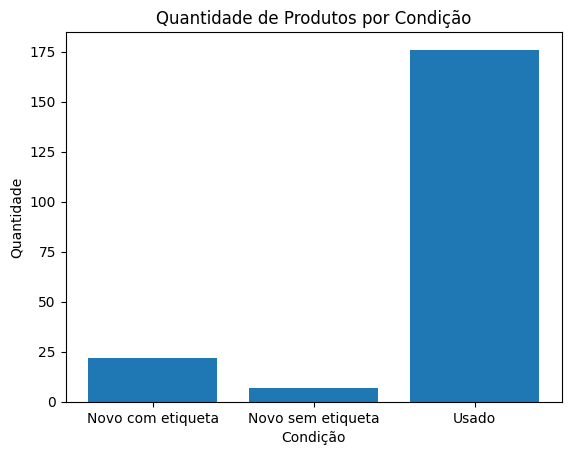

In [26]:
plt.bar(df_produtos['Condicao'], df_produtos['Quantidade'])
plt.title('Quantidade de Produtos por Condição')
plt.xlabel('Condição')
plt.ylabel('Quantidade')
plt.show()

Agora precisamos ranquear os produtos que mais foram pedidos por **quantidade** para entender a necessidade de um estoque de produtos na loja.

In [12]:
sql_df('SELECT * FROM PRODUTOS').head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [13]:
sql_df('SELECT * FROM ITENS_PEDIDOS').head(3)

,id_nf,produto_id,pedido_id,quantidade,valor_unitario,valor_total,Estado,frete
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0


In [21]:
query = '''SELECT ITENS_PEDIDOS.PRODUTO_ID, PRODUTOS.PRODUTO, SUM(ITENS_PEDIDOS.QUANTIDADE) AS Quantidade
FROM ITENS_PEDIDOS, PRODUTOS
WHERE ITENS_PEDIDOS.PRODUTO_ID = PRODUTOS.PRODUTO_ID
GROUP BY PRODUTOS.PRODUTO
ORDER BY Quantidade ASC'''

df_prod_quant = sql_df(query)
df_prod_quant

,produto_id,produto,Quantidade
0,47682,Vestido Malha Estampa,318
1,84743,Blusa Listrada Malha,322
2,88368,Blusa Malha Azul,325
3,32986,Blusa Babados Off-white,337
4,2706,Blusa Cinza,341
...,...,...,...
196,32126,Saia Midi Cinto,549
197,11218,Calca Alfaiataria Preta,750
198,72667,Saia Pregas Preta,751
199,98640,Calca Jeans Costuras,755


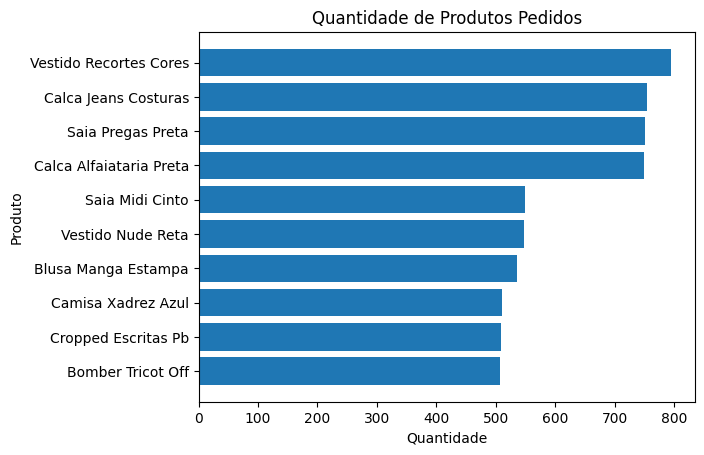

In [25]:
plt.barh(df_prod_quant['produto'][-10:], df_prod_quant['Quantidade'][-10:])
plt.title('Quantidade de Produtos Pedidos')
plt.xlabel('Quantidade')
plt.ylabel('Produto')
plt.show()

Calcular a receita total obtida com a venda de itens. Na tabela itens_pedidos, o valor total dos itens representa o cálculo da quantidade pelo valor unitário e pode ser considerado como a receita da venda.

In [28]:
receita_total = itens_pedidos['valor_total'].sum()
print(f'A receita total obtida com a venda de itens é de R$ {receita_total:.2f}')

A receita total obtida com a venda de itens é de R$ 45803930.00


Identificar quais as 15 marcas que foram as mais pedidas por quantidade de vendas.

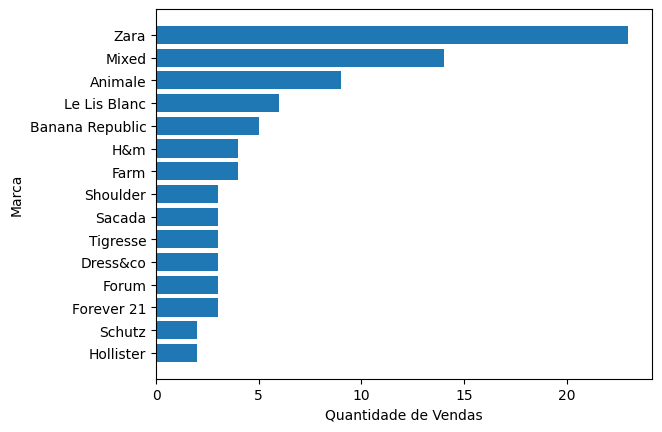

In [48]:
df_marcas = produtos['marca'].value_counts().head(15).sort_values(ascending=True)
df_marcas = pd.DataFrame(df_marcas)
plt.barh(df_marcas.index, df_marcas['count'])
#plt.title('Quantidade de Produtos Pedidos por Marca')
plt.xlabel('Quantidade de Vendas')
plt.ylabel('Marca')
plt.show()

# 3. Lidando com filtro

Vamos iniciar uma análise de desempenho do **time de vendedores** da Meteora. A intenção aqui é entender como se deram as vendas dos vendedores no **ano anterior** para que possam ser aplicadas promoções e bônus salarial para a equipe no ano atual da tabela que é 2021

In [49]:
sql_df('SELECT * FROM PEDIDOS').head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [51]:
sql_df('SELECT * FROM PEDIDOS').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pedido_id    24527 non-null  int64 
 1   produto_id   24527 non-null  int64 
 2   vendedor_id  24527 non-null  int64 
 3   data_compra  24527 non-null  object
 4   total        24527 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 958.2+ KB


Para entender o desempenho de vendas dos vendedores no ano de 2020, é preciso trabalhar com os dados que estão presentes apenas no ano de 2020.

In [57]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade Vendas' FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY COUNT(PEDIDOS.PEDIDO_ID) DESC;
'''

sql_df(query)

,nome_vendedor,Quantidade Vendas
0,Ana Duarte,3427
1,Daniel Siqueira,3338
2,Nadia Oliveira,2782
3,Millena Pereira,2510
4,Paulo Calanca,2488


In [58]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, AVG(PEDIDOS.TOTAL) AS 'Média por vendas' FROM PEDIDOS, VENDEDORES
WHERE strftime('%Y', data_compra) = '2020' AND VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY AVG(PEDIDOS.TOTAL) DESC;
'''

sql_df(query)

,nome_vendedor,Média por vendas
0,Daniel Siqueira,1972.338526
1,Millena Pereira,1894.614343
2,Ana Duarte,1843.452582
3,Nadia Oliveira,1818.342200
4,Paulo Calanca,1813.469855


 Exibir os 10 produtos mais vendidos durante o ano de 2019

In [64]:
produtos.head(3)

,produto_id,produto,preco,marca,sku,Condicao
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482,Usado


In [65]:
pedidos.head(3)

,pedido_id,produto_id,vendedor_id,data_compra,total
0,341,41518,5,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600


In [69]:
query = '''SELECT PRODUTOS.PRODUTO, COUNT(PEDIDOS.PEDIDO_ID) AS 'Quantidade Vendas' FROM PEDIDOS, PRODUTOS
WHERE strftime('%Y', data_compra) = '2019' AND PRODUTOS.PRODUTO_ID = PEDIDOS.PRODUTO_ID
ORDER BY COUNT(PRODUTOS.PRODUTO) DESC;
'''

sql_df(query)

,produto,Quantidade Vendas
0,Calca Jeans Basica,8167


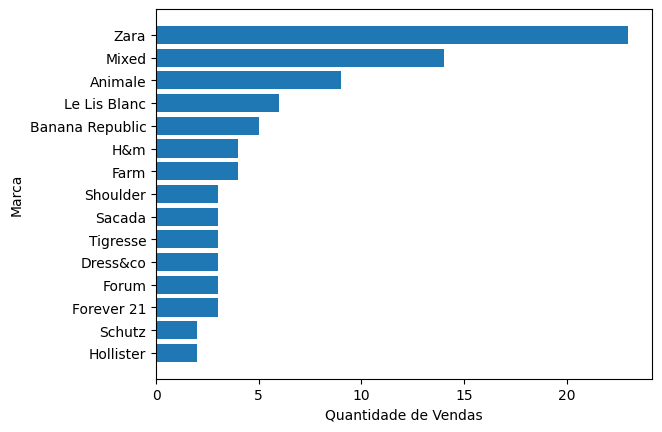

In [62]:
df_produtos = produtos['marca'].value_counts().head(15).sort_values(ascending=True)
df_marcas = pd.DataFrame(df_marcas)
plt.barh(df_marcas.index, df_marcas['count'])
#plt.title('Quantidade de Produtos Pedidos por Marca')
plt.xlabel('Quantidade de Vendas')
plt.ylabel('Marca')
plt.show()

Publicar a distribuição através dos meses da receita obtida em vendas no ano de 2021

# 4. Avançando nas relações

A Meteora agora deseja incrementar as suas vendas no **estado de São Paulo (SP)**, por acreditar ser uma região mais propícia às vendas já que tem uma boa concentração de pessoas e mercado também.

Mas será que São Paulo já não rende muitas vendas em relação a outros estados?

In [70]:
query = ''' SELECT ESTADO, COUNT(*) AS 'Pedidos'
FROM ITENS_PEDIDOS
GROUP BY ESTADO
ORDER BY Pedidos DESC;
'''

sql_df(query)

,Estado,Pedidos
0,BR-MA,974
1,BR-DF,953
2,BR-MT,937
3,BR-GO,933
4,BR-PA,932
5,BR-AL,928
6,BR-PE,927
7,BR-RR,925
8,BR-RO,925
9,BR-RN,921


Uma das ações que a Meteora pretende seguir para as vendas em SP é escolher dois de seus vendedores para que eles **foquem suas vendas** lá. Para essa escolha é interessante ter os profissionais que **mais tenham vendido** para as pessoas da região.

In [74]:
query = '''SELECT VENDEDORES.NOME_VENDEDOR, COUNT(*) AS quantidade_vendas
FROM PEDIDOS
JOIN VENDEDORES ON VENDEDORES.VENDEDOR_ID = PEDIDOS.VENDEDOR_ID
JOIN ITENS_PEDIDOS ON ITENS_PEDIDOS.PEDIDO_ID = PEDIDOS.PEDIDO_ID
WHERE ITENS_PEDIDOS.ESTADO = 'BR-SP'
GROUP BY VENDEDORES.NOME_VENDEDOR
ORDER BY quantidade_vendas DESC;
'''

sql_df(query)

,nome_vendedor,quantidade_vendas
0,Daniel Siqueira,190
1,Paulo Calanca,182
2,Nadia Oliveira,181
3,Ana Duarte,180
4,Millena Pereira,157


Listar as marcas vendidas em São Paulo por quantidade de pedidos.

Publicar os produtos que são mais vendidos na época de Natal no Brasil todo.

*MySQL com sqlalchemy*

In [ ]:
from sqlalchemy import create_engine

# Configuração da conexão com o banco de dados
user = 'seu_usuario'
password = 'sua_senha'
host = 'localhost'
database = 'nome_do_banco_de_dados'

# Criar uma string de conexão
connection_string = f'mysql+mysqlconnector://{user}:{password}@{host}/{database}'

# Criar o engine de conexão
engine = create_engine(connection_string)

# Estabelecer a conexão
conn = engine.connect()

# A partir daqui, podemos executar consultas ou operações no banco de dados
## […]

# Fechar a conexão quando terminar
conn.close()

*PostgreSQL com sqlalchemy*

In [ ]:
from sqlalchemy import create_engine

# Configuração da conexão com o banco de dados
user = 'seu_usuario'
password = 'sua_senha'
host = 'localhost'
database = 'nome_do_banco_de_dados'

# Criar uma string de conexão
connection_string = f'postgresql://{user}:{password}@{host}/{database}'

# Criar o engine de conexão
engine = create_engine(connection_string)

# Estabelecer a conexão
conn = engine.connect()

# A partir daqui, podemos executar consultas ou operações no banco de dados
## […]

# Fechar a conexão quando terminar
conn.close()